# Objectif du script :

Le script va tout d'abord importer tous les modèles crées jusque là : 
- Modèles A : modèles basés sur les bases DVF + compléments : modèle qui va prédire le prix de base
- Modèles B : modèles basés sur les annonces scrapées : modèle qui va prédire un bonus / malus en fonction des propriétés du bien

Le script va ensuite prendre en input les propriétés d'une annonce et les transformer pour calculer les inputs des modèles

Le script va enfin prédire le prix final recommandé du bien avec la formule suivante
prix_final = prix issu du modèle A + bonus ou malus issu du modèle B


In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from joblib import load

In [30]:
# Applique-t-on le bonus/malus ?
application_bonus = 0    # On décide de le désactiver car les résultats ne sont pas OK
                         # La prédiction ne sera alors basée que sur le modèle A
                         # Il est toutefois possible de l'activer pour voir ce que cela donne

Exemple d'annonce : https://www.superimmo.com/annonces/achat-maison-100m-saint-hilaire-31410-xn1esj

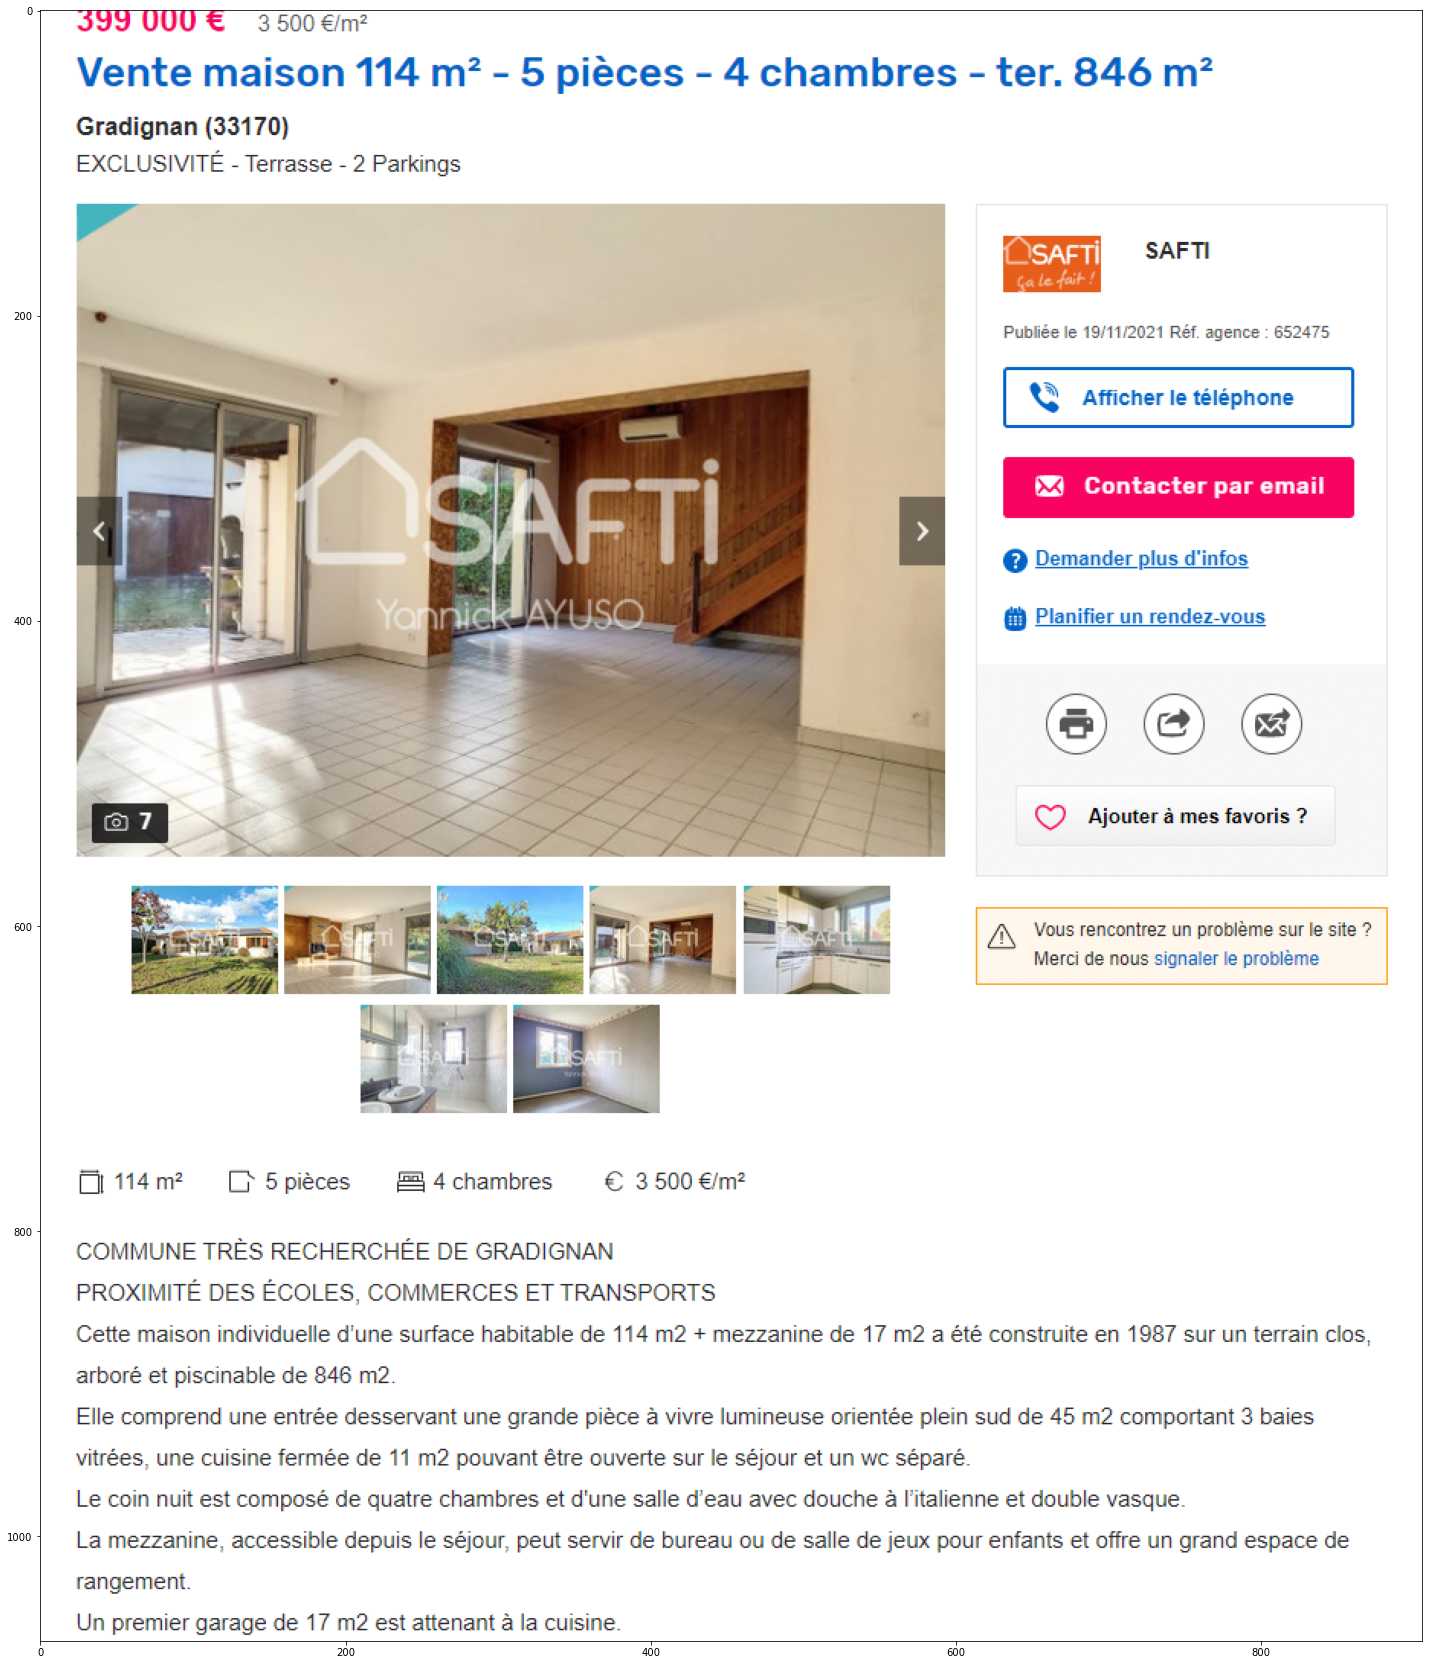

In [31]:
image = img.imread('models/demo.png')
plt.figure(figsize = (40,30))
plt.imshow(image)
plt.show()

In [4]:
# Renseigner ici les propriétés du bien

prix_annonce = 399000

# Emplacement du bien
rue = "Rue Montaigne"                # Nom de la rue / Si inconnu, mettre une rue du quartier
cp = 33170
ville = "Gradignan"

surface_terrain = 846
surface = 114
type_local = 1              # 0 si appartement, 1 si maison
nb_pieces = 5
nb_chambres = 4             # Sera utilisé dans prédiction du Bonus / Malus
paris = 0
mer = 0
anciennete = 38
conso_energie = 187
estim_ges = 6

# Features pour prédiction Bonus / Malus
Exposition_Sud = 1
Lumineux = 1
Calme = 1
Volume =  0
Standing = 0
Charme = 1
Mezzanine = 1
Avec_Ascenseur = 0
Sans_Ascenseur = 0
Duplex = 0
Dernier_etage = 0 
Premier_etage = 0
Deuxieme_etage = 0
Troisieme_etage = 0
Quatrieme_etage = 0
Cinquieme_etage = 0
Sixieme_etage = 0
Septieme_etage = 0
Huitieme_etage = 0
RDC = 0
Design = 0
Terrasse = 0
Parfait_etat = 0
Travaux = 1
Proche_commodites = 0
Vue_degagee = 0
Securise = 0
Emplacement = 0
Atypique = 0
Nature = 1
Meuble = 0
Cave = 0
Parking = 0
Cuisine_americaine = 0
Investissement_locatif = 0
Proche_ecoles = 0
Dressing = 0
Plain_Pied = 1
Garage = 1
Grange = 0
Buanderie = 0
Dependance = 0

# Prédiction du prix de base

In [5]:
# Chargement des modèles A
model_A_all = load('models/model_rf_all.pkl')
model_A_appart_province = load('models/model_rf_1_appart_province.pkl')
model_A_appart_paris = load('models/model_rf_2_appart_paris.pkl')
model_A_maison_province = load('models/model_rf_3_maison_province.pkl')

In [6]:
# Chargement de la liste des features requis pour faire tourner le modèle
df_feat = pd.read_csv('models/features_list_for_model_A.csv', index_col = 0)
df_feat

,feature_name
0,Surface terrain
1,Surface reelle bati
2,Type local
3,Nombre pieces principales
4,Paris
5,Mer
6,prix m2 commune
7,prix m2 gps
8,Collège ou lycée
9,Crèche


In [7]:
from geopy.geocoders import Nominatim

adresse = rue + " " + str(cp) + " " + ville
code_dep = str(cp)[0:2]
# code_insee = ??

geolocator = Nominatim(user_agent="pyPredImmo")

try:
    location = geolocator.geocode(adresse, country_codes = 'fr', timeout = 5)
    lon = round(location.longitude, 2)
    lat = round(location.latitude, 2)
    print(adresse + " ===> " + str(lat) + "," + str(lon))

except:
    print('L\'adresse du bien n\'a pas été trouvée')

Rue Montaigne 33170 Gradignan ===> 44.78,-0.62


In [8]:
prix_m2_commune = pd.read_csv('models/prix_m2_commune.csv', dtype = {'Code postal': int})
prix_m2_gps = pd.read_csv('models/prix_m2_gps.csv')

In [9]:
# Identification du prix m2 de la commune
prix_m2_commune_bien = prix_m2_commune[(prix_m2_commune['Code postal'] == cp) & (prix_m2_commune['Type local'] == "Maison")]
prix_m2_commune_bien_val = prix_m2_commune_bien['Prix m2'].iloc[0]
prix_m2_commune_bien_val

3627.450980392157

In [10]:
# Identification du prix m2 du bloc GPS
prix_m2_gps_bien = prix_m2_gps[(prix_m2_gps['lon_2'] == lon) & (prix_m2_gps['lat_2'] == lat) & (prix_m2_gps['Type local'] == "Maison")]
prix_m2_gps_bien_val = prix_m2_gps_bien['Prix m2'].iloc[0]
prix_m2_gps_bien_val

3228.260869565217

In [11]:
# Recherche du loyer, population et revenus
df_other_feat = pd.read_csv('models/loy_rev_pop.csv', dtype = {'Code postal': int}, index_col = 0)
df_other_feat_bien = df_other_feat[(df_other_feat['Code postal'] == cp) & (df_other_feat['Type local'] == "Maison")]
df_other_feat_bien

,Code postal,Commune,Type local,loyer,Population totale,SNHMO18,SNHMFO18
111176,33170,GRADIGNAN,Maison,12.386933,25778.0,11.228406,9.859596


In [12]:
loyer = df_other_feat_bien['loyer'].iloc[0]
pop = df_other_feat_bien['Population totale'].iloc[0]
SNHMO18 = df_other_feat_bien['SNHMO18'].iloc[0]
SNHMFO18 = df_other_feat_bien['SNHMFO18'].iloc[0]

In [13]:
iris = pd.read_csv('databases/inter/02 - export_gps_iris_ALL_2020.csv')
iris.head()

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Adresse,Commune_Lat,Commune_Lon,lon,lat,Code departement,Code postal 5 chiffres,Code commune INSEE,code_iris_clean
0,FORTUNAT 1250 CEYZERIAT,46.183217,5.320072,5.323007,46.173753,01,1250.0,1072,10720000.0
1,TERRES DES CINQ SAULES 1290 LAIZ,46.246992,4.899335,4.892457,46.246330,01,1290.0,1203,12030000.0
2,BOIS DU CHAMP RION 1290 LAIZ,46.246992,4.899335,4.892457,46.246330,01,1290.0,1203,12030000.0
3,EN COROBERT 1290 LAIZ,46.246992,4.899335,4.881913,46.248368,01,1290.0,1203,12030000.0
4,RUE DE LA CHARTREUSE 1960 PERONNAS,46.171190,5.218022,5.227583,46.184979,01,1960.0,1289,12890102.0


In [14]:
# Récupération du code IRIS
possible_iris = iris[(iris['Adresse'].str.contains(rue.upper())) & (iris['Adresse'].str.contains(ville.upper()))
                    & (-iris['code_iris_clean'].isna())]

if possible_iris.shape[0] == 0:
    possible_iris = iris[iris['Adresse'].str.contains(ville.upper()) & (-iris['code_iris_clean'].isna())]

iris_annonce = int(possible_iris['code_iris_clean'].iloc[0])

In [15]:
bpe = pd.read_csv('databases/inter/03A - equipements_nb_clean.csv')
bpe.head()

,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,...,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport
0,10010000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,10040101,6,0,0,1,3,0,0,1,0,...,0,0,0,1,1,0,10,0,0,3
2,10040102,4,0,0,0,2,0,0,0,0,...,0,0,0,1,0,0,18,0,0,0
3,10040201,2,0,0,5,4,0,1,2,1,...,0,0,0,4,0,0,12,0,0,0
4,10040202,3,0,0,6,1,0,0,1,1,...,1,1,1,0,0,0,5,0,0,2


In [16]:
if iris_annonce == 0:
    college_lycee = 0
    creche = 0
    ecole = 0
    ecole_sup = 0
    gare = 0
    hotels = 0
    info_tour = 0
    police = 0
    salle_sport = 0
else:    
    college_lycee = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Collège ou lycée'])
    creche = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Crèche'])
    ecole = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Ecole mat et primaire'])
    ecole_sup = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Ecole sup'])
    gare = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Gare'])
    hotels = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Hotels'])
    info_tour = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Info touristique'])
    police = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Police ou gendarmerie'])
    salle_sport = int(bpe[bpe['code_iris_clean'] == iris_annonce]['Salle multisport'])

In [17]:
annonce_proprietes_A = [surface_terrain, surface, type_local, nb_pieces, paris, mer, prix_m2_commune_bien_val, 
                        prix_m2_gps_bien_val, college_lycee, creche, ecole, ecole_sup, gare, hotels, info_tour, police, 
                        salle_sport, anciennete, conso_energie, estim_ges, loyer, SNHMO18, SNHMFO18, pop]

annonce_proprietes_A

[846,
 114,
 1,
 5,
 0,
 0,
 3627.450980392157,
 3228.260869565217,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 1,
 1,
 38,
 187,
 6,
 12.3869332,
 11.22840629,
 9.859596036,
 25778.0]

In [18]:
annonce_proprietes_A = np.array(annonce_proprietes_A).reshape(1, df_feat.shape[0])

In [19]:
print(model_A_all.predict(annonce_proprietes_A))
print(model_A_appart_province.predict(annonce_proprietes_A))
print(model_A_appart_paris.predict(annonce_proprietes_A))
print(model_A_maison_province.predict(annonce_proprietes_A))

[383780.84131966]
[357930.96411101]
[1130412.65874103]
[396821.33313013]


C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [20]:
if paris == 1:
    prix_base_A = model_A_all.predict(annonce_proprietes_A)
elif type_local == 1:
    prix_base_A = model_A_maison_province.predict(annonce_proprietes_A)
elif type_local == 0:
    prix_base_A = model_A_appart_province.predict(annonce_proprietes_A)
else:
    prix_base_A = model_A_all.predict(annonce_proprietes_A)
    
prix_base_A

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([396821.33313013])

# Prédiction du Bonus / Malus

In [21]:
# Chargement des modèles B
model_B_maison = load('models/model_features_maison.pkl')
model_B_appart = load('models/model_features_appart.pkl')

In [22]:
# Chargement de la liste des features requis pour faire tourner le modèle
df_feat_b = pd.read_csv('models/features_list_for_model_B.csv', index_col = 0)

In [23]:
annonce_proprietes_B = [prix_base_A, surface, type_local, surface_terrain, nb_pieces, nb_chambres,
       Exposition_Sud, Lumineux, Calme, Volume, Standing, Charme,
       Mezzanine, Avec_Ascenseur, Sans_Ascenseur, Duplex,
       Dernier_etage, Premier_etage, Deuxieme_etage, Troisieme_etage,
       Quatrieme_etage, Cinquieme_etage, Sixieme_etage, Septieme_etage,
       Huitieme_etage, RDC, Design, Terrasse, Parfait_etat,
       Travaux, Proche_commodites, Vue_degagee, Securise,
       Emplacement, Atypique, Nature, Meuble, Cave, Parking,
       Cuisine_americaine, Investissement_locatif, Proche_ecoles,
       Dressing, Plain_Pied, Garage, Grange, Buanderie,
       Dependance]
annonce_proprietes_B = np.array(annonce_proprietes_B).reshape(1, df_feat_b.shape[0])

C:\Users\olivier\AppData\Local\Temp/ipykernel_13528/2999224213.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  annonce_proprietes_B = np.array(annonce_proprietes_B).reshape(1, df_feat_b.shape[0])


In [24]:
print(model_B_maison.predict(annonce_proprietes_B))
print(model_B_appart.predict(annonce_proprietes_B))

[0.11123252]
[0.14003823]


In [25]:
if type_local == 1:
    bonus_malus_B = model_B_maison.predict(annonce_proprietes_B)
else:
    bonus_malus_B = model_B_appart.predict(annonce_proprietes_B)
    
bonus_malus_B

array([0.11123252])

In [26]:
if application_bonus == 1:
    prix_predict_final = prix_base_A * (1 + (bonus_malus_B))
else:
    prix_predict_final = prix_base_A

In [27]:
def analyse_prix(prix_annonce, prix_predict_final):
    
    diff = prix_annonce / prix_predict_final - 1

    if diff > 0.1:
        print('Très au-dessus du marché')
    elif diff > 0.05:
        print('Au-dessus du marché')
    elif diff > -0.05:
        print('Offre équitable')
    elif diff > -0.1:
        print('Bonne affaire')
    else:
        print('Très bonne affaire')

In [28]:
print("Prix de l'annonce :", int(prix_annonce), "€")
print("Prédiction de prix :", int(prix_predict_final), "€")
print('\n')
print("Résultat :")
analyse_prix(prix_annonce, prix_predict_final)

Prix de l'annonce : 399000 €
Prédiction de prix : 396821 €


Résultat :
Offre équitable
